In [4]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

In [5]:
df = pd.read_csv("../vessel-total-clean-final.csv")

# Convertir la colonne date en datetime
df['base_date_time'] = pd.to_datetime(df['base_date_time'])

# Trier par mmsi + date (si plusieurs navires)
df = df.sort_values(['mmsi', 'base_date_time'])

In [14]:
df = df.sort_values(['mmsi', 'base_date_time'])
df['delta'] = df.groupby('mmsi')['base_date_time'].diff().dt.total_seconds()

# Choisis ici le MMSI à visualiser
mmsi_example = df['mmsi'].unique()[5]
df_boat = df[df['mmsi'] == mmsi_example].copy()

gaps = df_boat[df_boat['delta'] > 600]


In [18]:
# ── Diagnostic des gaps réels ──
print(f"=== Diagnostic pour le navire {mmsi_example} ===")
for i in range(1, len(df_boat)):
    t0 = df_boat.iloc[i-1]['base_date_time']
    t1 = df_boat.iloc[i  ]['base_date_time']
    gap = (t1 - t0).total_seconds()
    if gap > 600:
        print(f"Gap de {gap:.0f}s entre lignes {i-1} et {i} : {t0} → {t1}")
print("=== Fin du diagnostic ===\n")

=== Diagnostic pour le navire 241452000 ===
Gap de 2010s entre lignes 0 et 1 : 2023-05-25 10:41:39 → 2023-05-25 11:15:09
Gap de 797s entre lignes 7 et 8 : 2023-05-25 11:53:46 → 2023-05-25 12:07:03
Gap de 15870s entre lignes 8 et 9 : 2023-05-25 12:07:03 → 2023-05-25 16:31:33
Gap de 4920s entre lignes 9 et 10 : 2023-05-25 16:31:33 → 2023-05-25 17:53:33
Gap de 1188s entre lignes 10 et 11 : 2023-05-25 17:53:33 → 2023-05-25 18:13:21
Gap de 1390s entre lignes 11 et 12 : 2023-05-25 18:13:21 → 2023-05-25 18:36:31
Gap de 2039s entre lignes 14 et 15 : 2023-05-25 18:40:40 → 2023-05-25 19:14:39
Gap de 606s entre lignes 16 et 17 : 2023-05-25 19:19:27 → 2023-05-25 19:29:33
Gap de 637s entre lignes 21 et 22 : 2023-05-25 19:48:03 → 2023-05-25 19:58:40
Gap de 636s entre lignes 24 et 25 : 2023-05-25 20:12:33 → 2023-05-25 20:23:09
Gap de 889s entre lignes 26 et 27 : 2023-05-25 20:28:45 → 2023-05-25 20:43:34
Gap de 821s entre lignes 31 et 32 : 2023-05-25 21:05:16 → 2023-05-25 21:18:57
Gap de 726s entre li

In [15]:
def predict_gap(segment_df, model, step=300):
    """
    Remplit un gap par pas successifs de taille 'step' en secondes,
    en itérant la prédiction et en interpolant sog/cog.
    segment_df : DataFrame de 2 lignes [row_prev, row_next]
    """
    row_prev = segment_df.iloc[0]
    row_next = segment_df.iloc[1]
    t0 = row_prev['base_date_time']
    total_s = int((row_next['base_date_time'] - t0).total_seconds())
    n_steps = total_s // step

    # interpolation linéaire de sog et cog
    sogs = np.linspace(row_prev['sog'], row_next['sog'], n_steps+1)
    cogs = np.linspace(row_prev['cog'], row_next['cog'], n_steps+1)

    # état initial
    state = {
        'lat':    row_prev['lat'],
        'lon':    row_prev['lon'],
        'length': row_prev['length'],
        'draft':  row_prev['draft']
    }

    filled = []
    for i in range(1, n_steps):
        state['sog']     = sogs[i]
        state['cog']     = cogs[i]
        state['heading'] = row_prev['heading']

        X = pd.DataFrame([{**state, 'delta_seconds': step}])
        # réordonner les colonnes comme à l'entraînement
        try:
            X = X[model.feature_names_in_]
        except AttributeError:
            feature_order = ['lat','lon','sog','cog','heading','length','draft','delta_seconds']
            X = X[feature_order]

        lat_p, lon_p = model.predict(X)[0]
        t_pred = t0 + pd.Timedelta(seconds=i*step)

        filled.append({
            'mmsi':           row_prev['mmsi'],
            'base_date_time': t_pred,
            'lat':            lat_p,
            'lon':            lon_p
        })
        # mise à jour de la position pour l’itération suivante
        state['lat'], state['lon'] = lat_p, lon_p

    return pd.DataFrame(filled)

In [20]:
model = joblib.load("trajectoire.pkl")


step      = 300   # 5 min
threshold = 600   # 10 min

all_filled = []
for i in range(1, len(df_boat)):
    gap = df_boat.iloc[i]['delta']
    if gap <= threshold:
        continue

    row_prev = df_boat.iloc[i-1]
    row_next = df_boat.iloc[i]
    segment  = pd.DataFrame([row_prev, row_next])

    df_seg = predict_gap(segment, model, step=step)
    all_filled.append(df_seg)

filled_df = pd.concat(all_filled, ignore_index=True)
print("✅ Points prédits pour comblement :", len(filled_df))

✅ Points prédits pour comblement : 1078


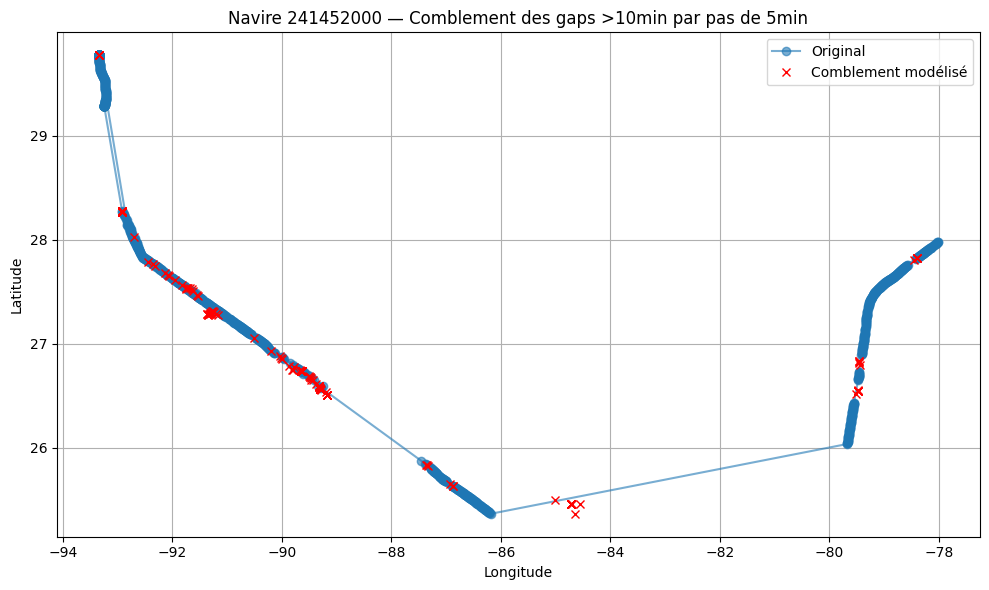

In [23]:
plt.figure(figsize=(10,6))
# trajectoire mesurée
plt.plot(df_boat['lon'], df_boat['lat'], 'o-', label='Original', alpha=0.6)
# prédictions comblées
plt.plot(filled_df['lon'], filled_df['lat'], 'x', label='Comblement modélisé', color='red')

plt.title(f"Navire {mmsi_example} — Comblement des gaps >10min par pas de 5min")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Total points comblés : 1342


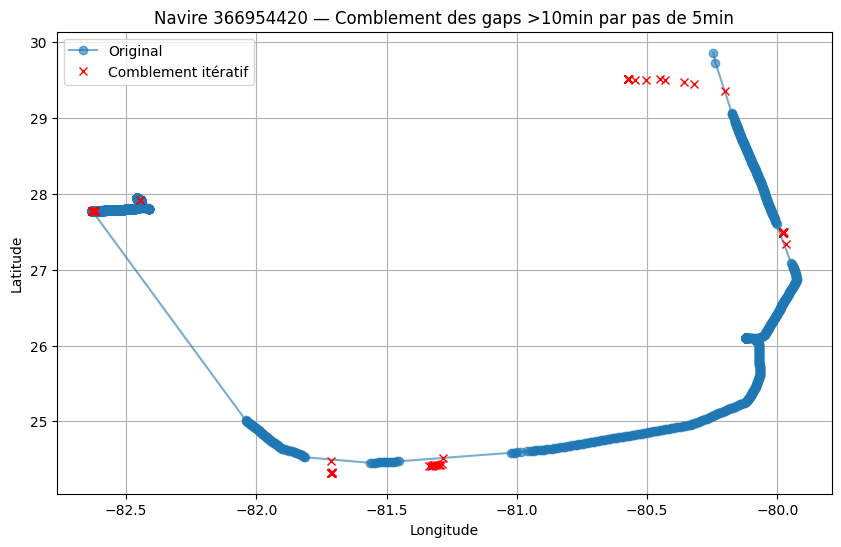

In [28]:
# ───────────────────────────────────────────────────────────────
# (Re)préparation complète + comblement + affichage
# ───────────────────────────────────────────────────────────────

import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

# 1) Charger modèle et données
model = joblib.load("trajectoire.pkl")
df = pd.read_csv("../vessel-total-clean-final.csv", parse_dates=['base_date_time'])

# 2) Filtrer un MMSI et réinitialiser l'index
mmsi_example = df['mmsi'].unique()[5]  # prends le deuxième pour ton cas
df_boat = (
    df[df['mmsi'] == mmsi_example]
    .sort_values('base_date_time')
    .reset_index(drop=True)
)

# 3) Recalculer les deltas
df_boat['delta'] = df_boat['base_date_time'].diff().dt.total_seconds()

# 4) Définir la fonction de comblement itératif
def predict_gap(segment_df, model, step=300):
    row_prev = segment_df.iloc[0]
    row_next = segment_df.iloc[1]
    t0 = row_prev['base_date_time']
    total_s = int((row_next['base_date_time'] - t0).total_seconds())
    n_steps = total_s // step

    sogs = np.linspace(row_prev['sog'], row_next['sog'], n_steps+1)
    cogs = np.linspace(row_prev['cog'], row_next['cog'], n_steps+1)

    state = {
        'lat':    row_prev['lat'],
        'lon':    row_prev['lon'],
        'length': row_prev['length'],
        'draft':  row_prev['draft']
    }

    filled = []
    for i in range(1, n_steps):
        state['sog']     = sogs[i]
        state['cog']     = cogs[i]
        state['heading'] = row_prev['heading']

        X = pd.DataFrame([{**state, 'delta_seconds': step}])
        # réordonner
        try:
            X = X[model.feature_names_in_]
        except:
            feat = ['lat','lon','sog','cog','heading','length','draft','delta_seconds']
            X = X[feat]

        lat_p, lon_p = model.predict(X)[0]
        t_pred = t0 + pd.Timedelta(seconds=i*step)

        filled.append({
            'mmsi':           row_prev['mmsi'],
            'base_date_time': t_pred,
            'lat':            lat_p,
            'lon':            lon_p
        })
        state['lat'], state['lon'] = lat_p, lon_p

    return pd.DataFrame(filled)

# 5) Boucler sur chaque paire consécutive
step = 300
threshold = 600

all_filled = []
for i in range(1, len(df_boat)):
    if df_boat.loc[i, 'delta'] > threshold:
        seg = pd.DataFrame([df_boat.iloc[i-1], df_boat.iloc[i]])
        df_seg = predict_gap(seg, model, step=step)
        all_filled.append(df_seg)

filled_df = pd.concat(all_filled, ignore_index=True)
print("Total points comblés :", len(filled_df))

# 6) Affichage
plt.figure(figsize=(10,6))
plt.plot(df_boat['lon'], df_boat['lat'], '-o', label='Original', alpha=0.6)
plt.plot(filled_df['lon'], filled_df['lat'], 'xr', label='Comblement itératif')
plt.title(f"Navire {mmsi_example} — Comblement des gaps >10min par pas de 5min")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(True)
plt.show()